In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib


%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
train_path = ('data_folder/Training/')
test_path = ('data_folder/Testing/')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #image net
])

In [ ]:
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)
print(len(train_dataset), len(test_dataset))

2870 394


In [ ]:
train_loader=DataLoader(
    train_dataset,
    batch_size=32, shuffle=True,
)
test_loader=DataLoader(
    test_dataset,
    batch_size=32, shuffle=True
)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64 * 12 * 12, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 4)

    def forward(self, x):
        #print('x_shape:',x.shape)
        out = self.conv1(x)
        #print('1_shape:',out.shape)
        out = self.conv2(out)
        #print('2_shape:',out.shape)
        out = self.conv3(out)
        #print('3_shape:',out.shape)
        out = self.conv4(out)
        #print('4_shape:',out.shape)
        out = out.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()


In [ ]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=20):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                train_epoch_true_hits.sum()
                / train_epoch_true_hits.size(0)
                / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                val_epoch_true_hits.sum()
                / val_epoch_true_hits.size(0)
                / val_dataloader.batch_size
            ).item(),
        )

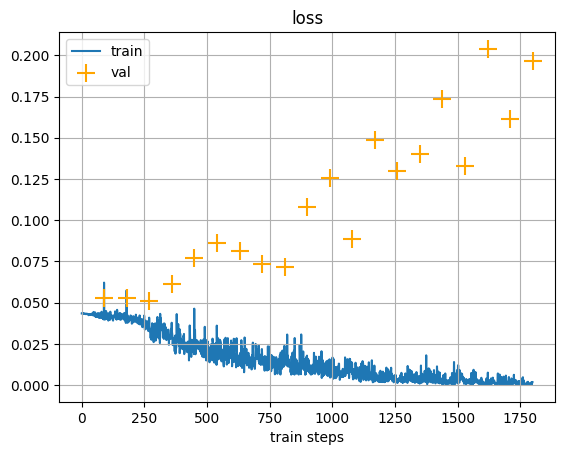

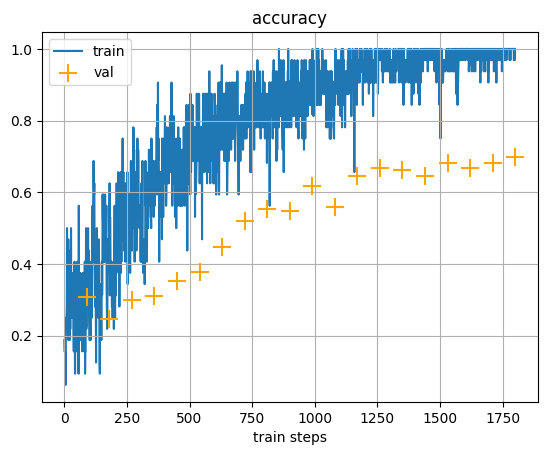

Train loss: 0.0012296150671318173
Train acc: 0.9854166507720947
Val loss: 0.19663096964359283
Val acc: 0.6971153616905212


In [ ]:
model_baseline = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_loader, test_loader)

In [ ]:
class ConvNet_regul_drop(nn.Module):
    def __init__(self):
        super(ConvNet_regul_drop, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64 * 12 * 12, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 4)

    def forward(self, x):
        #print('x_shape:',x.shape)
        out = self.conv1(x)
        #print('1_shape:',out.shape)
        out = self.conv2(out)
        #print('2_shape:',out.shape)
        out = self.conv3(out)
        #print('3_shape:',out.shape)
        out = self.conv4(out)
        #print('4_shape:',out.shape)
        out = out.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

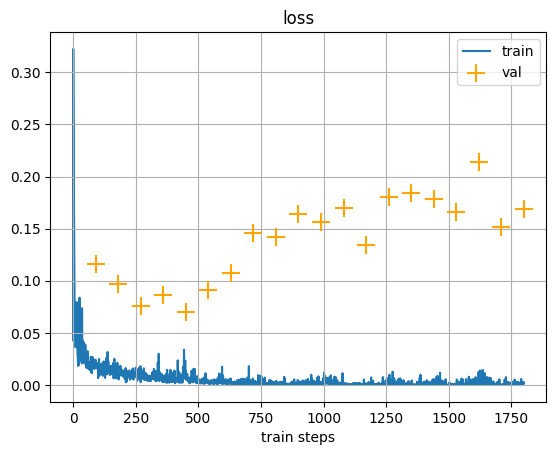

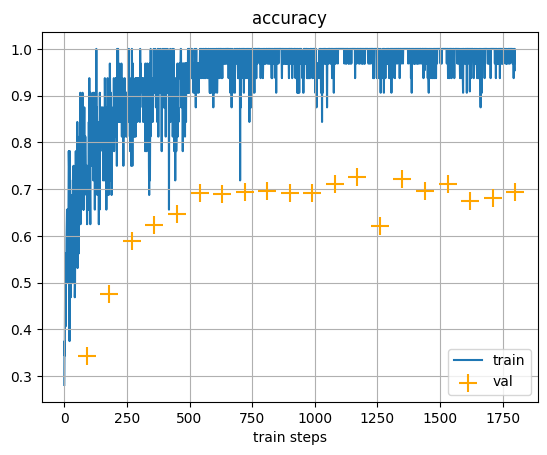

Train loss: 0.0010317267151549459
Train acc: 0.9857639074325562
Val loss: 0.16877517104148865
Val acc: 0.6947115659713745


In [ ]:
model_baseline = ConvNet_regul_drop().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=0.001)
train(model_baseline, criterion, optimizer, train_loader, test_loader)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64 * 12 * 12, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 4)

    def forward(self, x):
        #print('x_shape:',x.shape)
        out = self.conv1(x)
        #print('1_shape:',out.shape)
        out = self.conv2(out)
        #print('2_shape:',out.shape)
        out = self.conv3(out)
        #print('3_shape:',out.shape)
        out = self.conv4(out)
        #print('4_shape:',out.shape)
        #out = out.view(x.size(0), -1)
        out = nn.Flatten()(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

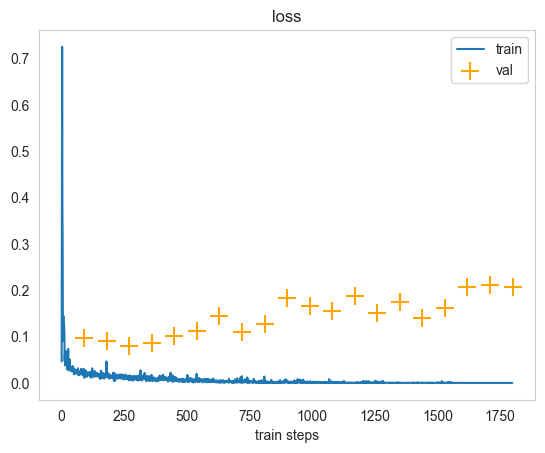

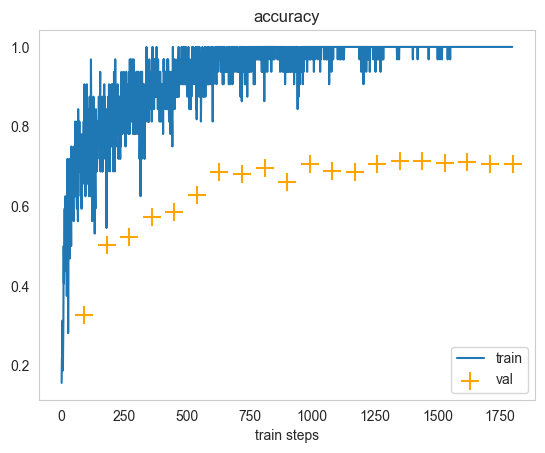

Train loss: 1.5214688573905732e-05
Train acc: 0.9965277910232544
Val loss: 0.2066868096590042
Val acc: 0.7067307829856873


In [ ]:
model_baseline = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=0.001)
train(model_baseline, criterion, optimizer, train_loader, test_loader)

In [ ]:
class Net_new(nn.Module):
    def __init__(self):
        super(Net_new, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        self.fc1 = nn.Linear(96 * 3 * 3, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 4)

    def forward(self, x):
        #print('x_shape:',x.shape)
        out = self.conv1(x)
        #print('1_shape:',out.shape)
        out = self.conv2(out)
        #print('2_shape:',out.shape)
        out = self.conv3(out)
        #print('3_shape:',out.shape)
        out = self.conv4(out)
        #print('4_shape:',out.shape)
        out = self.conv5(out)
        #print('5_shape:',out.shape)
        out = self.conv6(out)
        print('6_shape:',out.shape)
        #out = out.view(x.size(0), -1)
        out = nn.Flatten()(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

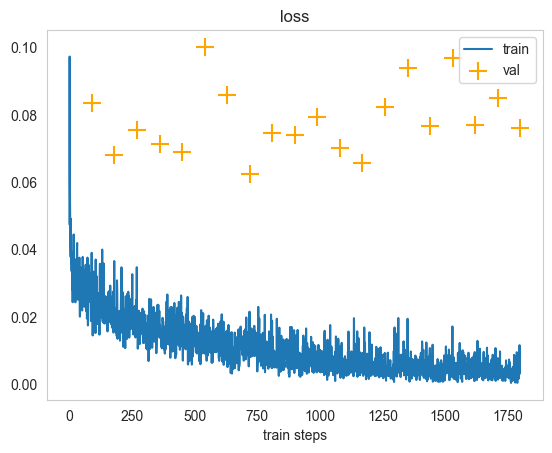

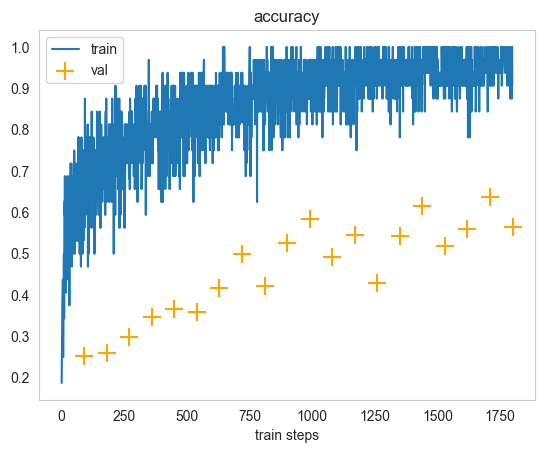

Train loss: 0.003653969382867217
Train acc: 0.9548611044883728
Val loss: 0.07617375999689102
Val acc: 0.5649038553237915


In [ ]:
model_baseline = Net_new().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=0.001)
train(model_baseline, criterion, optimizer, train_loader, test_loader)

In [ ]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64 * 5 * 5, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 4)

    def forward(self, x):
        #print('x_shape:',x.shape)
        out = self.conv1(x)
        #print('1_shape:',out.shape)
        out = self.conv2(out)
        #print('2_shape:',out.shape)
        out = self.conv3(out)
        out = self.conv4(out)
        #print('3_shape:',out.shape)
        out = self.conv5(out)
        #print('4_shape:',out.shape)
        #out = out.view(x.size(0), -1)
        out = nn.Flatten()(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

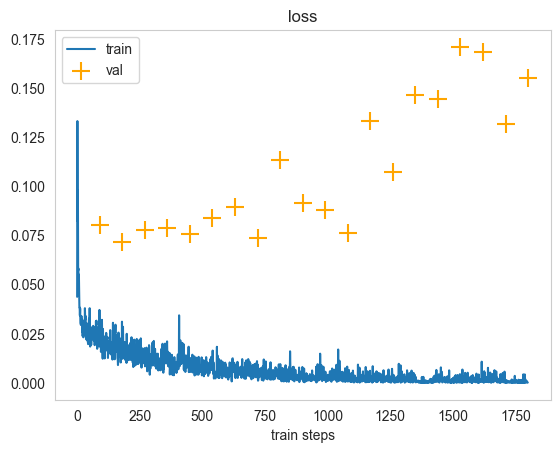

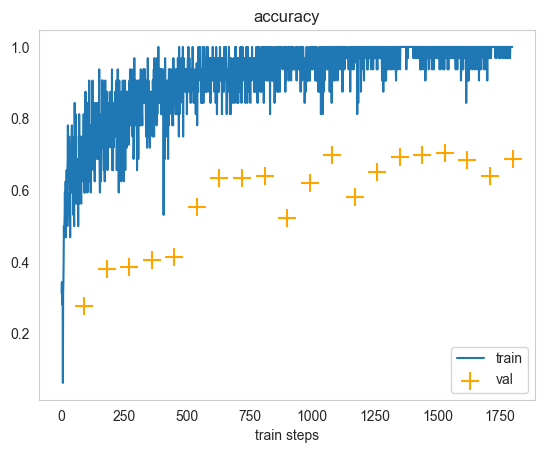

Train loss: 0.0006609273259527981
Train acc: 0.9916666746139526
Val loss: 0.15519343316555023
Val acc: 0.6875


In [ ]:
model_baseline = Net_2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=0.001)
train(model_baseline, criterion, optimizer, train_loader, test_loader)